# CEOS Data Cube - WOFS Water Classifier
*****

**Description:** This Python notebook allows users to directly interact with a CEOS-formatted data cube to perform analyses for water management. The following steps will allow users to connect to a data cube, define the analysis location and time period (extent of latitude/longitude and dates), and then run the Australian Water Observations from Space (WOFS) algorithm. The outputs of the WOFS algorithm include static and time series pixel-level water observations for any pixel. These results provide critical information for water management that will allow users to assess water cycle dynamics, historical water extent and the risk of floods and droughts. Future versions may consider the addition of water quality parameters (e.g. Total Suspended Matter, Chlorophyll-A, CDOM), coastal erosion analyses and in-situ precipitation and surface temperature data.  

#### Sensors: Landsat 8, Landsat 7 (lasrc)

*****

**Import necessary Data Cube libraries and dependencies.**

In [4]:
%matplotlib inline

from datetime import datetime
import numpy as np

import datacube
from utils.data_cube_utilities.dc_water_classifier import wofs_classify
from utils.data_cube_utilities.dc_utilities import perform_timeseries_analysis, create_cfmask_clean_mask
import dc_au_colormaps
import math

from utils.data_cube_utilities.dc_display_map import display_map
from dc_notebook_utilities import create_platform_product_gui, generate_metadata_report, show_map_extents, create_extents_gui, create_acq_date_gui

'Basemap' was not found in 'mpl_toolkits.basemap'.  It is likely that 'mpl_toolkits.basemap' is not present


**First, we must connect to our data cube.** We can then query the contents of the data cube we have connected to, including both the metadata and the actual data.

In [5]:
dc = datacube.Datacube(app='dc-water-analysis', config="/home/localuser/.datacube.conf")
api = datacube.api.API(datacube=dc)

**Obtain the metadata of our cube...** Initially, we need to get the platforms and products in the cube. The rest of the metadata will be dependent on these two options.

In [6]:
# Get available products
products = dc.list_products()

platform_names = list(set(products.platform))
product_names = list(products.name)

**Execute the following code and then use the generated form to choose your desired platfrom and product.**

In [7]:
#Only Landsats can do WOFS water detection
platform_names = [x for x in platform_names if ("LANDSAT" in x)]

#List viable options
product_values = create_platform_product_gui(platform_names, product_names, dc)

interactive(children=(Select(description='platform', options=('LANDSAT_5', 'LANDSAT_8', 'LANDSAT_7'), value='LANDSAT_5'), Output()), _dom_classes=('widget-interact',))

In [10]:
platform, product  = product_values
print(product, platform)

['ls7_ledaps_kenya'] ['LANDSAT_7']


In [11]:
product[0]

'ls7_ledaps_kenya'

In [13]:
lat, lon = products.resolution[products.platform == platform[0]].any()

**With the platform and product, we can get the rest of the metadata.** This includes the resolution of a pixel, the latitude/longitude extents, and the minimum and maximum dates available of the chosen platform/product combination.

In [14]:
# Save the form values
platform = product_values[0]
product = product_values[1]

# Get the pixel resolution of the selected product
lat_dist,lon_dist = lat, lon

# Get the extents of the cube
descriptor = api.get_descriptor(dict(platform = platform))[product[0]]

min_date = descriptor['result_min'][0]
min_lat = descriptor['result_min'][1]
min_lon = descriptor['result_min'][2]

min_date_str = str(min_date.year) + '-' + str(min_date.month) + '-' + str(min_date.day)

min_lat_rounded = round(min_lat, 3)
min_lon_rounded =  round(min_lon, 3)

max_date = descriptor['result_max'][0]
max_lat = descriptor['result_max'][1] 
max_lon = descriptor['result_max'][2] 

max_date_str = str(max_date.year) + '-' + str(max_date.month) + '-' + str(max_date.day)

max_lat_rounded = round(max_lat, 3) #calculates latitude of the pixel's center
max_lon_rounded = round(max_lon, 3) #calculates longitude of the pixel's center

# Display metadata
generate_metadata_report(min_date_str, max_date_str, 
                         min_lon_rounded, max_lon_rounded, lon_dist,
                         min_lat_rounded, max_lat_rounded, lat_dist)

display_map(latitude = (min_lat_rounded, max_lat_rounded),longitude = (min_lon_rounded, max_lon_rounded))

,Min,Max,Resolution
Date:,2005-1-8,2016-12-24,
Longitude:,34.655,36.899,0.000269995
Latitude:,-0.942,0.95,-0.000271302


**Execute the following code and then use the generated form to choose the extents of your desired data.**

In [15]:
extent_values = create_extents_gui(min_date_str, max_date_str,
                                   min_lon_rounded, max_lon_rounded,
                                   min_lat_rounded, max_lat_rounded)

Label(value='Start date: ')

Text(value='')

Label(value='End date: ')

Text(value='')

Label(value='Min lon: ')

BoundedFloatText(value=34.655, max=36.899, min=34.655)

Label(value='Max lon: ')

BoundedFloatText(value=35.655, max=36.899, min=34.655)

Label(value='Min lat: ')

BoundedFloatText(value=0.0, max=0.95, min=-0.942)

Label(value='Max lat: ')

BoundedFloatText(value=0.95, max=0.95, min=-0.942)

**Now that we have filled out the above two forms, we have enough information to query our data cube.** The following code snippet ends with the actual Data Cube query, which will return the dataset with all the data matching our query.

In [11]:
# Save form values
start_date = datetime.strptime(extent_values[0].value, '%Y-%m-%d')
end_date = datetime.strptime(extent_values[1].value, '%Y-%m-%d')
min_lon = extent_values[2].value
max_lon = extent_values[3].value
min_lat = extent_values[4].value
max_lat = extent_values[5].value

dict(platform=platform,
     product=product,
     time=(start_date, end_date),
     lon=(min_lon_rounded, max_lon_rounded), 
     lat=(min_lat_rounded, max_lat_rounded),
     measurements = ["red", "green", "blue", 
                     "nir", "swir1", "swir2", 
                     "pixel_qa"])

# Query the Data Cube
dataset_in = dc.load(platform=platform[0],
                     product=product[0],
                     time=(start_date, end_date),
                     lon=(min_lon, max_lon), 
                     lat=(min_lat, max_lat),
                     measurements = ["red", "green", "blue", 
                                     "nir", "swir1", "swir2", 
                                     "pixel_qa"])

if(len(dataset_in) is 0):
    print("no compatible dataset loaded in for WOFS detection")
else:
    print("successfully loaded data")

successfully loaded data


**At this point, we have finished accessing our data cube and we can turn to analyzing our data.** In this example, we will run the WOfS algorithm. The wofs_classify function, seen below, will return a modified dataset, where a value of 1 indicates the pixel has been classified as water by the WoFS algorithm and 0 represents the pixel is non-water.

*****

For more information on the WOfS algorithm, refer to:

Mueller, et al. (2015) "Water observations from space: Mapping surface water from 25 years of Landsat imagery across Australia." *Remote Sensing of Environment*.

In [12]:
from utils.data_cube_utilities.dc_mosaic import ls8_unpack_qa, ls7_unpack_qa, ls5_unpack_qa
if(platform[0] == "LANDSAT_7"):
    clear_xarray  = ls7_unpack_qa(dataset_in.pixel_qa, "clear")  
    water_xarray  = ls7_unpack_qa(dataset_in.pixel_qa, "water")
elif(platform[0] == "LANDSAT_8"):
    clear_xarray  = ls8_unpack_qa(dataset_in.pixel_qa, "clear")  
    water_xarray  = ls8_unpack_qa(dataset_in.pixel_qa, "water")
else:
    clear_xarray  = ls5_unpack_qa(dataset_in.pixel_qa, "clear")  
    water_xarray  = ls5_unpack_qa(dataset_in.pixel_qa, "water")
    
clean_mask = np.logical_or(clear_xarray.values.astype(bool),
                           water_xarray.values.astype(bool))

# clean_mask = create_cfmask_clean_mask(dataset_in.cf_mask)
water_class = wofs_classify(dataset_in, clean_mask=clean_mask)

In [13]:
np.unique(water_class.wofs.values)

array([-9.999e+03,  0.000e+00,  1.000e+00])

**Execute the following code and then use the generated form to choose your desired acquisition date.** The following two code blocks are only necessary if you would like to see the water mask of a single acquisition date. 

In [14]:
acq_dates = list(water_class.time.values.astype(str))
acq_date_input = create_acq_date_gui(acq_dates)

Label(value='Acquisition Date: ')

Dropdown(options=('2013-01-14T07:45:05.000000000', '2013-02-15T07:45:09.000000000', '2013-03-03T07:45:06.000000000', '2013-03-19T07:45:04.000000000', '2013-04-04T07:45:00.000000000', '2013-04-20T07:44:54.000000000', '2013-05-06T07:44:51.000000000', '2013-05-22T07:44:48.000000000', '2013-06-23T07:44:34.000000000', '2013-07-09T07:44:22.000000000', '2013-07-25T07:44:16.000000000', '2013-08-10T07:44:10.000000000', '2013-08-26T07:44:22.000000000', '2013-09-11T07:44:34.000000000', '2013-09-27T07:44:43.000000000', '2013-10-29T07:45:02.000000000', '2013-11-14T07:45:08.000000000', '2013-12-16T07:45:17.000000000', '2014-01-01T07:45:24.000000000', '2014-01-17T07:45:35.000000000', '2014-02-02T07:45:51.000000000', '2014-03-06T07:45:45.000000000', '2014-03-22T07:45:52.000000000', '2014-04-23T07:46:08.000000000', '2014-05-09T07:46:13.000000000', '2014-05-25T07:46:19.000000000', '2014-06-10T07:46:22.000000000', '2014-06-26T07:46:25.000000000', '2014-07-28T07:46:34.000000000', '2014-08-13T07:46:37.000000000', '2014-08-29T07:46:35.000000000', '2014-09-14T07:46:36.000000000', '2014-09-30T07:46:48.000000000', '2014-10-16T07:46:57.000000000', '2014-11-01T07:47:08.000000000', '2014-11-17T07:47:12.000000000', '2014-12-19T07:47:29.000000000', '2015-01-04T07:47:30.000000000', '2015-01-20T07:47:30.000000000', '2015-02-05T07:47:39.000000000', '2015-02-21T07:47:45.000000000', '2015-03-09T07:47:51.000000000', '2015-03-25T07:48:00.000000000', '2015-04-26T07:48:14.000000000', '2015-05-12T07:48:23.000000000', '2015-06-13T07:48:34.000000000', '2015-06-29T07:48:36.000000000', '2015-07-15T07:48:42.000000000', '2015-07-31T07:48:44.000000000', '2015-08-16T07:48:48.000000000', '2015-09-01T07:48:47.000000000', '2015-09-17T07:48:54.000000000', '2015-10-03T07:48:54.000000000', '2015-10-19T07:49:14.000000000', '2015-11-04T07:49:27.000000000', '2015-11-20T07:49:45.000000000', '2015-12-06T07:49:58.000000000', '2015-12-22T07:50:14.000000000', '2016-01-07T07:50:28.000000000', '2016-01-23T07:50:41.000000000', '2016-02-08T07:50:49.000000000', '2016-02-24T07:50:50.000000000', '2016-03-11T07:51:01.000000000', '2016-03-27T07:51:07.000000000', '2016-04-12T07:51:12.000000000', '2016-05-14T07:51:21.000000000', '2016-06-15T07:51:31.000000000', '2016-07-01T07:51:31.000000000', '2016-07-17T07:51:32.000000000', '2016-08-18T07:51:35.000000000', '2016-09-03T07:51:39.000000000', '2016-09-19T07:51:41.000000000', '2016-10-05T07:51:43.000000000', '2016-10-21T07:51:41.000000000', '2016-11-06T07:51:35.000000000'), value='2013-01-14T07:45:05.000000000')

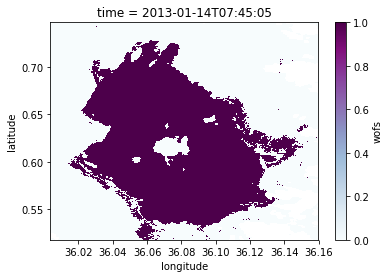

In [16]:
# Save form value
acq_date = acq_date_input.value
acq_date_index = acq_dates.index(acq_date)

# Get water class for selected acquisition date and mask no data values
water_class_for_acq_date = water_class.wofs[acq_date_index]
water_class_for_acq_date.values = water_class_for_acq_date.values.astype('float')
water_class_for_acq_date.values[water_class_for_acq_date.values == -9999] = np.nan

water_observations_for_acq_date_plot = water_class_for_acq_date.plot(cmap='BuPu')

**With all of the pixels classified as either water/non-water, let's perform a time series analysis over our derived water class.** The function, perform_timeseries_analysis, takes in a dataset of 3 dimensions (time, latitude, and longitude), then sums the values of each pixel over time. It also keeps track of the number of clear observations we have at each pixel. We can then normalize each pixel to determine areas at risk of flooding. The normalization calculation is simply:

$$normalized\_water\_observations = \dfrac{total\_water\_observations}{total\_clear\_observations}$$.

The output each of the three calculations can be seen below.

In [17]:
time_series = perform_timeseries_analysis(water_class, 'wofs')

**The following plots visualize the results of our timeseries analysis.** You may change the color scales with the cmap option. For color scales available for use by cmap, see http://matplotlib.org/examples/color/colormaps_reference.html. You can also define discrete color scales by using the levels and colors. For example:

* normalized_water_observations_plot = normalized_water_observations.plot(levels=3, colors=['#E5E5FF', '#4C4CFF', '#0000FF'])
* normalized_water_observations_plot = normalized_water_observations.plot(levels=[0.00, 0.50, 1.01], colors=['#E5E5FF', '#0000FF'])

For more examples on how you can modify plots, see http://xarray.pydata.org/en/stable/plotting.html.

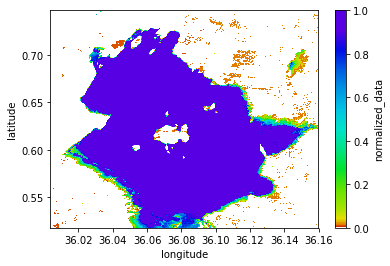

In [18]:
normalized_water_observations_plot = time_series.normalized_data.plot(cmap='dc_au_WaterSummary')

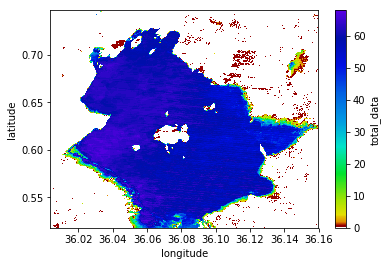

In [19]:
total_water_observations_plot = time_series.total_data.plot(cmap='dc_au_WaterObservations')

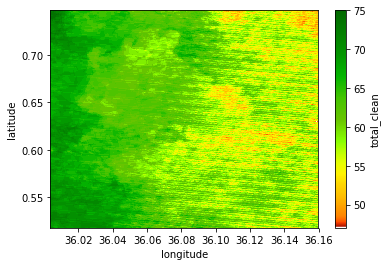

In [20]:
total_clear_observations_plot = time_series.total_clean.plot(cmap='dc_au_ClearObservations')